In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
# from keras.models import Sequential
# from keras.layers import Dense
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
# import torch
# import torch.nn as nn
# import torch.optim as optim
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from pyod.models.hbos import HBOS

In [5]:
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


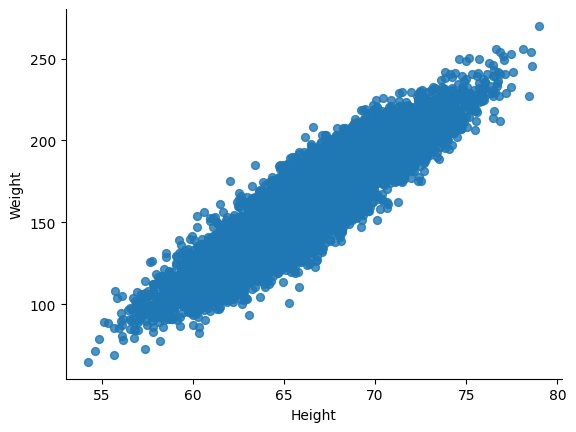

In [6]:
weight_height.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Задание 1. Сравнение моделей обучения с учителем (4 балла)
Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (scatter plot) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

- Interquartile range (IQR) — возьмите выбросы по x и y.
- Isolation forest.
- Local Outlier Factor.
- One-class SVM.
- Gaussian Mixture.
- DBSCAN.

Напишите, какие модели показали себя лучше всего и почему.

Критерии оценивания:

- 1 балл за каждую правильно построенную модель и корректно выведенные выбросы (всего 3 балла).
- 1 балл за правильное оформление графиков и полотна графиков.


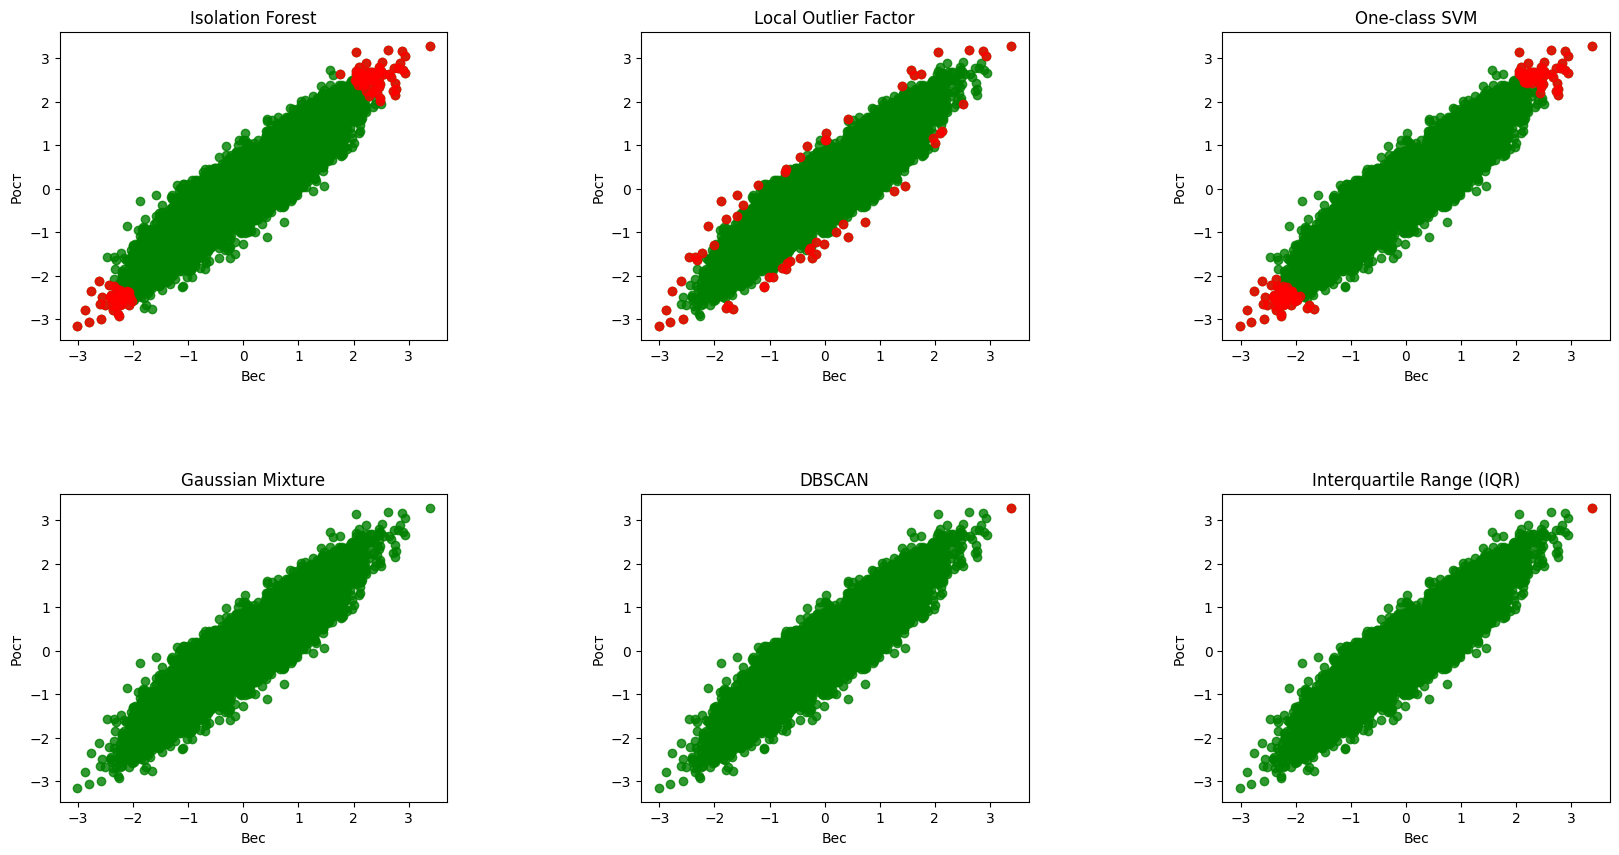

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Загрузка данных
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')

# Выборка только веса и роста
data = weight_height[['Weight', 'Height']]

# Нормализация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Создание сетки графиков
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

# Функция для визуализации данных с использованием различных алгоритмов
def plot_data(ax, title, data, model):
    pred = model.fit_predict(data)
    anomalies = data[pred == -1]
    ax.scatter(data[:, 0], data[:, 1], c='green', alpha=0.8)
    ax.scatter(anomalies[:, 0], anomalies[:, 1], c='red', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Вес')
    ax.set_ylabel('Рост')

# Функция для вычисления и визуализации выбросов с использованием IQR
def plot_iqr(ax, title, data):
    data_df = pd.DataFrame(data, columns=['weight', 'height'])
    Q1 = data_df['weight'].quantile(0.25)
    Q3 = data_df['weight'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data_df[(data_df['weight'] < (Q1 - 1.5 * IQR)) | (data_df['weight'] > (Q3 + 1.5 * IQR))]
    ax.scatter(data_df['weight'], data_df['height'], c='green', alpha=0.8)
    ax.scatter(outliers['weight'], outliers['height'], c='red', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Вес')
    ax.set_ylabel('Рост')

# Заполнение сетки графиков
titles = ['Isolation Forest', 'Local Outlier Factor', 'One-class SVM', 'Gaussian Mixture', 'DBSCAN', 'Interquartile Range (IQR)']
models = [
    IsolationForest(contamination=0.01),
    LocalOutlierFactor(),
    OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01),
    GaussianMixture(n_components=2, covariance_type='full'),
    DBSCAN(eps=0.5, min_samples=5),
    None # Для IQR не требуется модель
]

for ax, title, model in zip(axs.flatten(), titles, models):
    if model is None:
        plot_iqr(ax, title, data_scaled)
    else:
        plot_data(ax, title, data_scaled, model)

plt.show()


Судя по графикам, Isolation Forest и One-class SVM с задачей справились лучше остальных методов

# Задание 2. Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
После обучения модели выполните следующее:

- Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в sklearn.model_selection.GridSearchCV). В GridSearchCV используйте params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}.
- Сделайте предсказания на данных Х.
- Поиграйте с параметром n_jobs — создайте 6 разных визуализаций с параметрами от 1 до 6.
- Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
- Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).

Критерии оценивания:

- 1 балл за правильное использование GridSearchCV для подбора параметров в IsolationForest.
- 2 балла за правильный вывод параметров для шести моделей с разным параметром n_jobs.


In [24]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


In [17]:
times

[14.95998239517212]

In [18]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

url = 'https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv'
thyroid = pd.read_csv(url, sep=';').iloc[:, :-2]
thyroid['Outlier_label '] = thyroid['Outlier_label '].apply(lambda x: -1 if x=='o' else 1)

params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}

model = IsolationForest()
grid_search = GridSearchCV(model, params, cv=5, scoring='f1_macro', n_jobs=1)
grid_search.fit(thyroid)

print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'max_features': 2, 'n_estimators': 5}
